In [1]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 13.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 16.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 241.0/241.0 kB 13.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 8.2 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=8e9d859bc25367898f3aaee476f923e9f3ab72ad78429ebc808718ab74bb7637
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [2]:
import tensorflow as tf### models
import numpy as np### math computations
import matplotlib.pyplot as plt### plots
import sklearn### machine learning library
import cv2## image processing
from sklearn.metrics import confusion_matrix, roc_curve### metrics
import seaborn as sns### visualizations
import datetime
import io
import os
import random
from google.colab import files
from PIL import Image
import albumentations as A
import tensorflow_datasets as tfds
import tensorflow_probability as tfp
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, InputLayer, BatchNormalization, Input, Dropout, RandomFlip, RandomRotation, Resizing, Rescaling
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import BinaryAccuracy, FalsePositives, FalseNegatives, TruePositives, TrueNegatives, Precision, Recall, AUC, binary_accuracy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import Callback, CSVLogger, EarlyStopping, LearningRateScheduler, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.regularizers  import L2, L1
from tensorboard.plugins.hparams import api as hp
from google.colab import drive
import wandb
from wandb.keras import WandbCallback

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
!wandb login

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit: 
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


In [5]:
wandb.init(project="Malaria-Detection", entity="willy_kinfoussia")

wandb: Currently logged in as: willy-kinfoussia (willy_kinfoussia). Use `wandb login --relogin` to force relogin


In [6]:
wandb.config = {
  "LEARNING_RATE": 0.001,
  "N_EPOCHS": 20,
  "BATCH_SIZE": 128,
  "DROPOUT_RATE": 0.0,
  "IM_SIZE": 224,
  "REGULARIZATION_RATE": 0.0,
  "N_FILTERS": 6,
  "KERNEL_SIZE": 3,
  "N_STRIDES": 1,
  "POOL_SIZE": 2,
  "N_DENSE_1": 100,
  "N_DENSE_2": 10,
}
CONFIGURATION = wandb.config

In [7]:
dataset, dataset_info = tfds.load('malaria', with_info=True,
                                  as_supervised=True,
                                  shuffle_files = True,
                                  split=['train'])

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete1HRWRX/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


In [8]:
def SplitDataset(dataset, TRAIN_RATIO, VAL_RATIO, TEST_RATIO):
  DATASET_SIZE = len(dataset)

  train_dataset = dataset.take(int(TRAIN_RATIO*DATASET_SIZE))

  val_test_dataset = dataset.skip(int(TRAIN_RATIO*DATASET_SIZE))
  val_dataset = val_test_dataset.take(int(VAL_RATIO*DATASET_SIZE))

  test_dataset = val_test_dataset.skip(int(VAL_RATIO*DATASET_SIZE))
  return train_dataset, val_dataset, test_dataset

In [9]:
TRAIN_RATIO = 0.8
VAL_RATIO = 0.1
TEST_RATIO = 0.1

train_dataset, val_dataset, test_dataset = SplitDataset(dataset[0], TRAIN_RATIO, VAL_RATIO, TEST_RATIO )

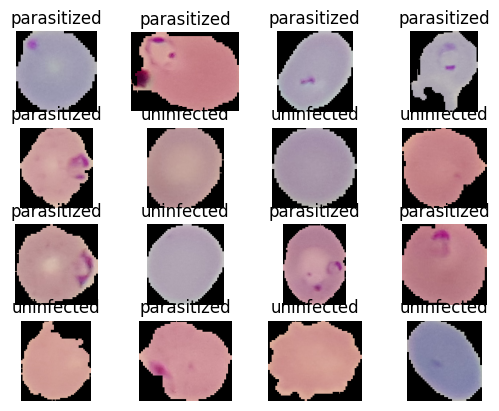

In [10]:
for i, (image, label) in enumerate(train_dataset.take(16)):
  ax = plt.subplot(4, 4, i + 1)

  plt.imshow(image)
  plt.title(dataset_info.features['label'].int2str(label))
  plt.axis('off')

In [11]:
IM_SIZE = CONFIGURATION['IM_SIZE']
DROPOUT_RATE = CONFIGURATION['DROPOUT_RATE']
REGULARIZATION_RATE = CONFIGURATION['REGULARIZATION_RATE']
N_FILTERS = CONFIGURATION['N_FILTERS']
KERNEL_SIZE = CONFIGURATION['KERNEL_SIZE']
POOL_SIZE = CONFIGURATION['POOL_SIZE']
N_STRIDES = CONFIGURATION['N_STRIDES']

In [12]:
def ResizingRescaleImage(image, label):
  return tf.image.resize(image, (IM_SIZE, IM_SIZE))/255.0, label

In [13]:
train_dataset = train_dataset.map(ResizingRescaleImage)
val_dataset = val_dataset.map(ResizingRescaleImage)

In [14]:
train_dataset = train_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)
val_dataset = val_dataset.shuffle(buffer_size = 8, reshuffle_each_iteration = True).batch(32).prefetch(tf.data.AUTOTUNE)

In [15]:
train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [16]:
val_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

## Sequential API

In [17]:


lenet_model = tf.keras.Sequential([
    InputLayer(input_shape = (IM_SIZE, IM_SIZE, 3)),

    Conv2D(filters = N_FILTERS , kernel_size = KERNEL_SIZE, strides = N_STRIDES , padding='valid',
          activation = 'relu',kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),
    Dropout(rate = DROPOUT_RATE ),

    Conv2D(filters = N_FILTERS*2 + 4, kernel_size = KERNEL_SIZE, strides=N_STRIDES, padding='valid',
          activation = 'relu', kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    MaxPool2D (pool_size = POOL_SIZE, strides= N_STRIDES*2),

    Flatten(),

    Dense( CONFIGURATION['N_DENSE_1'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),
    Dropout(rate = DROPOUT_RATE),

    Dense( CONFIGURATION['N_DENSE_2'], activation = "relu", kernel_regularizer = L2(REGULARIZATION_RATE)),
    BatchNormalization(),

    Dense(1, activation = "sigmoid"),

])

lenet_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      6

In [18]:
metrics = [TruePositives(name='tp'),FalsePositives(name='fp'), TrueNegatives(name='tn'), FalseNegatives(name='fn'),
          BinaryAccuracy(name='accuracy'), Precision(name='precision'), Recall(name='recall'), AUC(name='auc')]
FACTOR = 1
LABELS = ['Parasitized', 'Uninfected']

In [19]:
lenet_model.compile(optimizer = Adam(learning_rate = CONFIGURATION['LEARNING_RATE']),
                    loss = BinaryCrossentropy(),
                    metrics = metrics)

In [20]:
history = lenet_model.fit(
            train_dataset,
            validation_data = val_dataset,
            epochs = CONFIGURATION['N_EPOCHS'],
            verbose = 1,
            callbacks=[WandbCallback()]
          )

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/20
689/689 [==============================] - ETA: 0s - loss: 0.3990 - tp: 9101.0000 - fp: 2036.0000 - tn: 8987.0000 - fn: 1922.0000 - accuracy: 0.8205 - precision: 0.8172 - recall: 0.8256 - auc: 0.9011

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231019_080445-erir52ag/files/model-best)... Done. 0.2s


689/689 [==============================] - 106s 127ms/step - loss: 0.3990 - tp: 9101.0000 - fp: 2036.0000 - tn: 8987.0000 - fn: 1922.0000 - accuracy: 0.8205 - precision: 0.8172 - recall: 0.8256 - auc: 0.9011 - val_loss: 0.5574 - val_tp: 1349.0000 - val_fp: 485.0000 - val_tn: 877.0000 - val_fn: 44.0000 - val_accuracy: 0.8080 - val_precision: 0.7356 - val_recall: 0.9684 - val_auc: 0.9330
Epoch 2/20
689/689 [==============================] - ETA: 0s - loss: 0.2194 - tp: 10255.0000 - fp: 1034.0000 - tn: 9989.0000 - fn: 768.0000 - accuracy: 0.9183 - precision: 0.9084 - recall: 0.9303 - auc: 0.9685

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231019_080445-erir52ag/files/model-best)... Done. 0.2s


689/689 [==============================] - 51s 74ms/step - loss: 0.2194 - tp: 10255.0000 - fp: 1034.0000 - tn: 9989.0000 - fn: 768.0000 - accuracy: 0.9183 - precision: 0.9084 - recall: 0.9303 - auc: 0.9685 - val_loss: 0.1953 - val_tp: 1335.0000 - val_fp: 136.0000 - val_tn: 1228.0000 - val_fn: 56.0000 - val_accuracy: 0.9303 - val_precision: 0.9075 - val_recall: 0.9597 - val_auc: 0.9725
Epoch 3/20
689/689 [==============================] - 47s 69ms/step - loss: 0.1931 - tp: 10341.0000 - fp: 881.0000 - tn: 10139.0000 - fn: 685.0000 - accuracy: 0.9290 - precision: 0.9215 - recall: 0.9379 - auc: 0.9755 - val_loss: 0.2692 - val_tp: 1357.0000 - val_fp: 204.0000 - val_tn: 1159.0000 - val_fn: 35.0000 - val_accuracy: 0.9132 - val_precision: 0.8693 - val_recall: 0.9749 - val_auc: 0.9648
Epoch 4/20
689/689 [==============================] - ETA: 0s - loss: 0.1652 - tp: 10477.0000 - fp: 785.0000 - tn: 10237.0000 - fn: 547.0000 - accuracy: 0.9396 - precision: 0.9303 - recall: 0.9504 - auc: 0.9818

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
wandb: Adding directory to artifact (/content/wandb/run-20231019_080445-erir52ag/files/model-best)... Done. 0.2s


689/689 [==============================] - 50s 72ms/step - loss: 0.1652 - tp: 10477.0000 - fp: 785.0000 - tn: 10237.0000 - fn: 547.0000 - accuracy: 0.9396 - precision: 0.9303 - recall: 0.9504 - auc: 0.9818 - val_loss: 0.1902 - val_tp: 1321.0000 - val_fp: 116.0000 - val_tn: 1248.0000 - val_fn: 70.0000 - val_accuracy: 0.9325 - val_precision: 0.9193 - val_recall: 0.9497 - val_auc: 0.9739
Epoch 5/20
689/689 [==============================] - 56s 81ms/step - loss: 0.1431 - tp: 10523.0000 - fp: 671.0000 - tn: 10352.0000 - fn: 500.0000 - accuracy: 0.9469 - precision: 0.9401 - recall: 0.9546 - auc: 0.9863 - val_loss: 0.2934 - val_tp: 1368.0000 - val_fp: 237.0000 - val_tn: 1123.0000 - val_fn: 27.0000 - val_accuracy: 0.9042 - val_precision: 0.8523 - val_recall: 0.9806 - val_auc: 0.9621
Epoch 6/20
689/689 [==============================] - 47s 68ms/step - loss: 0.1183 - tp: 10585.0000 - fp: 533.0000 - tn: 10490.0000 - fn: 438.0000 - accuracy: 0.9560 - precision: 0.9521 - recall: 0.9603 - auc: 0.9

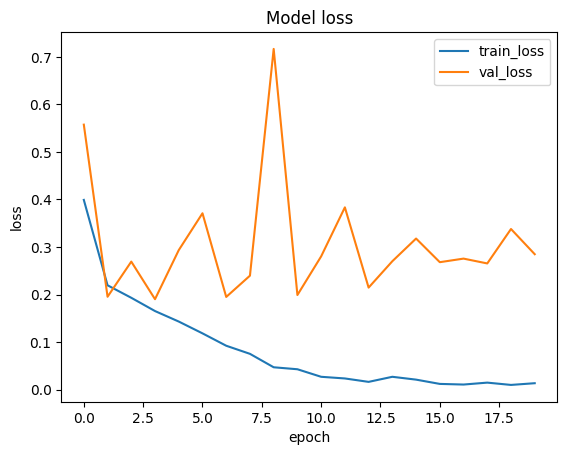

In [21]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

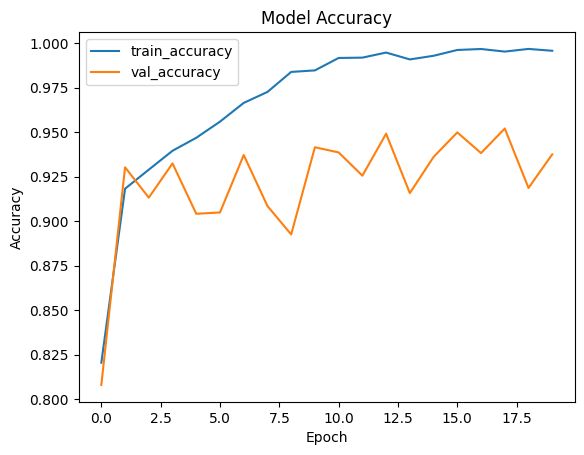

In [22]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

Save Model

In [23]:
lenet_model.save("lenet")

In [24]:
lenet_model.save("lenet.hdf5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
lenet_model.save_weights("weights/lenet_weights")

Load Model

In [27]:
lenet_loaded_model = tf.keras.models.load_model("lenet")
lenet_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      6

In [28]:
lenet_loaded_model = tf.keras.models.load_model("lenet.hdf5")
lenet_loaded_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 6)       168       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 6)       24        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 111, 111, 6)       0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 111, 111, 6)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 109, 109, 16)      880       
                                                                 
 batch_normalization_1 (Bat  (None, 109, 109, 16)      6

In [29]:
lenet_weights_model = lenet_model.load_weights("weights/lenet_weights")